<a href="https://colab.research.google.com/github/StevenLevine-NOAA/NBM-Verif/blob/notebooks/MDL_Internal_NBM_Reliability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NBM Reliability**
This python notebook grabs NBM data as well as station data, and computes reliability for NBM PMaxT, PMinT, or PQPF thresholds. Note, in the case of PQPF, conditional reliability is generated (stats only computed when precipitation was observed, because reasons, mainly the difficulty of ranking a 0 ob).

# **1 - Install & Import Packages**
This section will install and import all the packages we need.

This section only needs to run once!

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...


In [ ]:
!mamba install -q -c conda-forge cartopy contextily pyproj pyepsg pygrib netCDF4 tqdm
import numpy as np
import pandas as pd
from urllib.request import urlretrieve, urlopen
from datetime import datetime, timedelta
import json
import math
#!pip install pygrib
import pygrib
from netCDF4 import Dataset
import requests
import os, re, traceback

import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.axes as maxes
import matplotlib.patheffects as PathEffects
from matplotlib.path import Path
from matplotlib.textpath import TextToPath
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
matplotlib.rcParams['font.sans-serif'] = 'Liberation Sans'
matplotlib.rcParams['font.family'] = "sans-serif"
from sklearn.calibration import calibration_curve
import seaborn as sns
from pyproj import Proj, transform as pyproj_transform

import itertools
import warnings
warnings.filterwarnings("ignore")

#!pip install tqdm
from tqdm import tqdm_notebook as tqdm

#!pip uninstall shapely --yes
#!pip install shapely cartopy==0.19.0.post1 --no-binary shapely --no-binary cartopy
from cartopy import crs as ccrs, feature as cfeature

# **2 - Edit Form Options and Go!**
This is where you set the options. This is the last and only cell you really should have to edit. I recommend testing with a two days to make sure your output is what you expect before doing anything crazy, like queueing up and entire month. Your plots will appear inline, but plots and csvs are also available for download by clicking the folder icon in the bar on the left. It may be better to download this and run it locally if you can, since it can take some time if you selected a lot of dates and/or stations.

In [ ]:
#@title Options Selection
#@markdown Pick the element you want to look at
element = "maxt" #@param ["maxt", "mint", "qpf"]
threshold = 32 #@param ["- QPF -", "0.01", "0.10", "0.25", "0.50", "1.0", "2.0", "3.0", "4.0", "- MinT - ", "-40", "-20", "0", "28", "32", "80", "- MaxT -", "0", "28", "32", "80", "90", "100", "110", "120"]{type:"raw"}
#@markdown -------
#@markdown Pick a start date and end date
start_date = "2022-12-20" #@param {type:"date"}
end_date = "2023-01-11" #@param {type:"date"}
#@markdown -------
#@markdown Pick an NBM Lead time in days and QMD Initialization hour (choose carefully - suggested 00Z for Max and 12Z for Min). (3 = ~3-day/72-hr lead time)
nbm_lead_time = 2 #@param {type:"number"}
nbm_init_hour = 0 #@param {type:"slider", min:0, max:18, step:6}
#@markdown -------
#@markdown Pick a region and what you want to compare to the probabilities - NBM Determinstic or Observations
region_selection = "CWA" #@param ["WR", "SR", "CR", "ER", "CONUS","CWA"]
#@markdown If CWA selected, which one? (i.e. "SLC" for Salt Lake City)
cwa_id = "ILN" #@param {type:"string"}
cwa_outline = True #@param {type:"boolean"}

threshold= float(threshold)

if os.path.exists("nbm"):
  pass
else:
  os.system('mkdir nbm')

if os.path.exists("obs"):
  pass
else:
  os.system('mkdir obs')

if os.path.exists("csv"):
  pass
else:
  os.system('mkdir csv')

if element == "maxt":
  if threshold <= 32:
    percentile_stat = "nonexceedance"
    temp = "ColdMaxT"
  elif threshold >= 80:
    percentile_stat = "exceedance"
    temp = "HotMaxT"

elif element == "mint":
  if threshold <= 32:
    percentile_stat = "nonexceedance"
    temp = "ColdMinT"
  elif threshold >= 80:
    percentile_stat = "exceedance"
    temp= "HotMinT"
elif element == "qpf":
  percentile_stat = "exceedance"

 #@markdown Substitute precip obs with Stage IV values (useful in frozen precip)?
use_stageiv = False#@param {type:"boolean"}
#@markdown Which obs?
network_selection = "NWS" #@param ["NWS", "RAWS", "NWS+RAWS", "NWS+RAWS+HADS", "ALL", "CUSTOM", "LIST"]
#@markdown If Custom or List selected for network, enter comma separated network IDs (custom) or siteids (list)  WITH NO SPACES here. For help - https://developers.synopticdata.com/about/station-providers/
network_input = ""#@param {type:"string"}
network_dict = {"NWS+RAWS+HADS":"&network=1,2,106","NWS+RAWS":"&network=1,2", "NWS":"&network=1", "RAWS": "&network=2", "ALL":"", "CUSTOM": "&network="+network_input, "LIST": "&stid="+network_input}
network_string = network_dict[network_selection]


if region_selection == "CONUS":
  region_list = ["WR", "CR", "SR", "ER"]
elif region_selection == "CWA":
  region_list = [cwa_id]
else:
  region_list = [region_selection]

def cwa_list(input_region):
  region_dict ={"WR":"BYZ,BOI,LKN,EKA,FGZ,GGW,TFX,VEF,LOX,MFR,MSO,PDT,PSR,PIH,PQR,REV,STO,SLC,SGX,MTR,HNX,SEW,OTX,TWC",
              "CR":"ABR,BIS,CYS,LOT,DVN,BOU,DMX,DTX,DDC,DLH,FGF,GLD,GJT,GRR,GRB,GID,IND,JKL,EAX,ARX,ILX,LMK,MQT,MKX,MPX,LBF,APX,IWX,OAX,PAH,PUB,UNR,RIW,FSD,SGF,LSX,TOP,ICT",
              "ER":"ALY,LWX,BGM,BOX,BUF,BTV,CAR,CTP,RLX,CHS,ILN,CLE,CAE,GSP,MHX,OKX,PHI,PBZ,GYX,RAH,RNK,AKQ,ILM",
              "SR":"ABQ,AMA,FFC,EWX,BMX,BRO,CRP,EPZ,FWD,HGX,HUN,JAN,JAX,KEY,MRX,LCH,LZK,LUB,MLB,MEG,MAF,MFL,MOB,MRX,OHX,LIX,OUN,SJT,SHV,TAE,TBW,TSA"}
  if (input_region in ["WR", "CR", "SR", "ER"]):
    cwas_list = region_dict[input_region]
  else:
    cwas_list = input_region
  return cwas_list

synoptic_token = "ea497aaa40464749b903ac1204fd8020"
statistics_api = "https://api.synopticlabs.org/v2/stations/statistics?"
precipitation_api = "https://api.synopticdata.com/v2/stations/precipitation?"
metadata_api = "https://api.synopticdata.com/v2/stations/metadata?"

start_date = datetime.strptime(start_date,'%Y-%m-%d')
end_date = datetime.strptime(end_date,'%Y-%m-%d')

threshold_dict_qpf = {0.01:"0.254",0.10:"2.54",0.25:"6.35",0.50:"12.7",
                  1.00:"25.4",2.00:"50.8","3.00":"76.2","4.00":"101.6",
                  "5.00":"127","6.00":"152.4","8.00":"203.2","12.00":"304.8",
                  "18.00":"457.2","24.00":"609.6","30.00":"762"}
threshold_dict_mint = {-40:233,-20:244,0:255,28:270,
                  32:273,80:299}
threshold_dict_maxt = {0:255,28:270,32:273,80:299,
                      90:305,100:310,110:316,120:322}


if element == "qpf":
  threshold_q= threshold_dict_qpf[threshold]
elif element == "mint":
  threshold_q = threshold_dict_mint[threshold]
elif element == "maxt":
  threshold_q = threshold_dict_maxt[threshold]

bulk_stats = {}
valid_date = start_date
temp_vars = ["maxt","mint"]
if (region_selection == "CWA"):
  region_name = cwa_id
else:
  region_name = region_selection

def project(lon, lat, prj):
  lon = float(lon)
  lat = float(lat)

  outproj = prj
  inproj = Proj(init='epsg:4326')
  nbm_coords = pyproj_transform(inproj, outproj, lon, lat)
  coordX = nbm_coords[0]
  coordY = nbm_coords[1]
  #print(f'Lat: {lat}, Y: {coordY} | Lon: {lon}, X: {coordX}')
  return(coordX, coordY)


def ll_to_index(datalons, datalats, loclon, loclat):
  abslat = np.abs(datalats-loclat)
  abslon = np.abs(datalons-loclon)
  c = np.maximum(abslon, abslat)
  latlon_idx_flat = np.argmin(c)
  latlon_idx = np.unravel_index(latlon_idx_flat, datalons.shape)
  return(latlon_idx)

def project_hrap(lon, lat, s4x, s4y):
  lon = float(lon)
  lat = float(lat)

  globe = ccrs.Globe(semimajor_axis=6371200)
  hrap_ccrs = proj = ccrs.Stereographic(central_latitude=90.0,
                          central_longitude=255.0,
                          true_scale_latitude=60.0, globe=globe)
  latlon_ccrs = ccrs.PlateCarree()
  hrap_coords = hrap_ccrs.transform_point(lon,lat,src_crs=latlon_ccrs)
  hrap_idx = ll_to_index(s4x, s4y, hrap_coords[0], hrap_coords[1])

  return hrap_idx



def download_subset(remote_url, remote_file, local_filename):
  print("   > Downloading a subset of NBM gribs")
  local_file = "nbm/"+local_filename
  if "qmd" in remote_file:
    if element == "maxt":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':TMP:2 m above ground:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day max fcst:'
      else:
        search_string = f':TMP:2 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour max fcst:'
    elif element == "mint":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':TMP:2 m above ground:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day min fcst:'
      else:
        search_string = f':TMP:2 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour min fcst:'
    elif element == "qpf":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':APCP:surface:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day acc fcst:'
      else:
        search_string = f':APCP:surface:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour acc fcst:'
    elif element == "maxwind":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 == 0):
        search_string = f':WIND:10 m above ground:{str(int(nbm_qmd_forecasthour_start/24))}-{str(int(nbm_qmd_forecasthour/24))} hour max fcst:'
      else:
        search_string = f':WIND:10 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour max fcst:'
  elif "core" in remote_file:
    if element == "maxt":
      search_string = f':TMAX:2 m above ground:{str(int(nbm_core_forecasthour_start))}-{str(int(nbm_core_forecasthour))} hour max fcst:'
    elif element == "mint":
      search_string = f':TMIN:2 m above ground:{str(int(nbm_core_forecasthour_start))}-{str(int(nbm_core_forecasthour))} hour min fcst:'
    elif element == "snow":
      search_string = f':ASNOW:surface:{str(int(nbm_core_forecasthour_start))}-{str(int(nbm_core_forecasthour))} hour acc'
  #print("Search string = ",search_string)
  idx = remote_url+".idx"
  #print("IDX file = " + idx)
  r = requests.get(idx)
  if not r.ok:
    print('     ❌ SORRY! Status Code:', r.status_code, r.reason)
    print(f'      ❌ It does not look like the index file exists: {idx}')

  lines = r.text.split('\n')
  expr = re.compile(search_string)
  expr
  byte_ranges = {}
  for n, line in enumerate(lines, start=1):
    # n is the line number (starting from 1) so that when we call for
    # `lines[n]` it will give us the next line. (Clear as mud??)
    # Use the compiled regular expression to search the line
    #print(">> Searching throgh this line: " + line)
    if expr.search(line):
      # aka, if the line contains the string we are looking for...
      # Get the beginning byte in the line we found
      parts = line.split(':')
      rangestart = int(parts[1])
      # Get the beginning byte in the next line...
      if n+1 < len(lines):
        # ...if there is a next line
        parts = lines[n].split(':')
        rangeend = int(parts[1])
      else:
        # ...if there isn't a next line, then go to the end of the file.
        rangeend = ''

        # Store the byte-range string in our dictionary,
        # and keep the line information too so we can refer back to it.
      byte_ranges[f'{rangestart}-{rangeend}'] = line
      #print(line)
    #else:
      #print(">>>  Could not find search string!")
  #print(">>  Number of items in byteRange:" + str(len(byte_ranges)))
  for i, (byteRange, line) in enumerate(byte_ranges.items()):

    if i == 0:
      # If we are working on the first item, overwrite the existing file.
      curl = f'curl -s --range {byteRange} {remote_url} > {local_file}'
      #print(">>  Adding curl command: " + curl)
    else:
      # If we are working on not the first item, append the existing file.
      curl = f'curl -s --range {byteRange} {remote_url} >> {local_file}'
      #print("Adding curl command: " + curl)
    #print('>>  Parsing line: ' + line)
    try:
      num, byte, date, var, level, forecast, _ = line.split(':')
    except:
      pass
      #print(">>>  Can't get num/byte/etc from this line, so skipping...")

    #print(f'  Downloading GRIB line [{num:>3}]: variable={var}, level={level}, forecast={forecast}')
    #print(f'  Downloading GRIB line: variable={var}, level={level}, forecast={forecast}')
    #print("Running the curl command...")
    os.system(curl)

  if os.path.exists(local_file):
    print(f'      ✅ Success! Searched for [{search_string}] and got [{len(byte_ranges)}] GRIB fields and saved as {local_file}')
    return local_file
  else:
    print(print(f'      ❌ Unsuccessful! Searched for [{search_string}] and did not find anything!'))



def get_stageiv():
  siv_url = "https://water.weather.gov/precip/downloads/"+valid_date_end.strftime('%Y')+"/"+valid_date_end.strftime('%m')+"/"+valid_date_end.strftime('%d')+"/nws_precip_1day_"+valid_date_end.strftime('%Y%m%d')+"_conus.nc"
  data = urlopen(siv_url).read()

  nc = Dataset('data', memory=data)
  #with Dataset(siv_file, 'r') as nc:
  stageIV = nc.variables['observation']
  s4x = nc.variables['x']
  s4y = nc.variables['y']
  return stageIV, s4x, s4y

date_delta = end_date - start_date
datelist = [start_date + timedelta(days=d) for d in range(int(date_delta.days)+1)]


for valid_date in tqdm(datelist, desc="Looping over date range"):
  with tqdm(total=3, leave=False) as pbar:
    pbar.set_description(f"Working on day {valid_date.strftime('%Y-%m-%d')}")
    valid_date_string = valid_date.strftime('%Y%m%d')
    nbm_init_date = valid_date - timedelta(days=(nbm_lead_time - 1))
    nbm_init = nbm_init_date + timedelta(hours=int(nbm_init_hour))

    if element=="maxt":
      nbm_qmd_valid_hour="06"
      valid_date_start = valid_date
      valid_date_end = valid_date + timedelta(days=1)
      obs_start_hour = "1200"
      obs_end_hour = "0600"
      ob_stat = "maximum"
      valid_end_datetime = valid_date_end + timedelta(hours=(int(obs_end_hour)/100))
      nbm_qmd_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_qmd_valid_hour))


    elif element=="mint":
      nbm_qmd_valid_hour="18"
      valid_date_start = valid_date
      valid_date_end = valid_date
      obs_start_hour = "0000"
      obs_end_hour = "1800"
      ob_stat = "minimum"
      valid_end_datetime = valid_date_end + timedelta(hours=(int(obs_end_hour)/100))
      nbm_qmd_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_qmd_valid_hour))

    elif element=="qpf":
      nbm_qmd_valid_hour="12"
      valid_date_start = valid_date
      valid_date_end = valid_date + timedelta(days=1)
      obs_start_hour = "1200"
      obs_end_hour = "1200"
      ob_stat = "total"
      valid_end_datetime = valid_date_end + timedelta(hours=(int(obs_end_hour)/100))
      nbm_qmd_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_qmd_valid_hour))

    valid_input = valid_date_end + timedelta (hours=int(nbm_qmd_valid_hour))
    vt = valid_date_start.strftime('%a %m-%d-%Y')
    init = nbm_init.strftime('%HZ %Y-%m-%d')


    nbm_qmd_fhdelta = nbm_qmd_valid_end_datetime - nbm_init
    nbm_qmd_forecasthour = nbm_qmd_fhdelta.total_seconds() / 3600.
    if element=="qpf":
      nbm_qmd_forecasthour_start = nbm_qmd_forecasthour - 24
    else:
      nbm_qmd_forecasthour_start = nbm_qmd_forecasthour - 18


    obs ={}


    for region in region_list:
      pbar.set_description(f"Working on day {valid_date.strftime('%Y%m%d')} (Getting obs for {region})")
      if element == "qpf" and use_stageiv:
        json_name = "obs/"+region+"_nws_raws_locs.json"
      else:
        json_name = "obs/Obs_"+element+"_"+valid_date_start.strftime('%Y%m%d')+obs_start_hour+"_"+valid_date_end.strftime('%Y%m%d')+obs_end_hour+"_"+region+".json"

      if any(te in element for te in temp_vars):
        api_token = "&token="+synoptic_token
        station_query = "&cwa="+cwa_list(region)
        vars_query = "&vars=air_temp"
        start_query = "&start="+valid_date_start.strftime('%Y%m%d')+obs_start_hour
        end_query = "&end="+valid_date_end.strftime('%Y%m%d')+obs_end_hour
        stat_type = "&type="+ob_stat
        network_query = network_string
        api_extras = "&units=temp%7Cf&within=1440&status=active"
        obs_url = statistics_api + api_token + station_query + vars_query + start_query + end_query + stat_type + network_query + api_extras
      elif (element == "qpf"):
        if use_stageiv:
          api_token = "&token="+synoptic_token
          station_query = "&cwa="+cwa_list(region)
          api_extras = "&fields=status,latitude,longitude,name,elevation"
          network_query = network_string
          obs_url = metadata_api + api_token + station_query + network_query + api_extras
          stageIV, s4xs, s4ys = get_stageiv()
          s4xs, s4ys = np.meshgrid(s4xs, s4ys)
        else:
          api_token = "&token="+synoptic_token
          station_query = "&cwa="+cwa_list(region)
          api_extras = "&fields=status,latitude,longitude,name,elevation&obtimezone=utc"
          network_query = network_string
          vars_query = "&pmode=totals"
          units_query = "&units=precip|in"
          start_query = "&start="+valid_date_start.strftime('%Y%m%d')+obs_start_hour
          end_query = "&end="+valid_date_end.strftime('%Y%m%d')+obs_end_hour
          obs_url = precipitation_api + api_token + station_query + network_query + vars_query + start_query + end_query + units_query + api_extras
      #print(obs_url)
      if os.path.exists(json_name):
        pass
      else:
        urlretrieve(obs_url, json_name)

      if os.path.exists(json_name):
          with open(json_name) as json_file:
              obs_json = json.load(json_file)
              obs_lats = []
              obs_lons = []
              obs_value = []
              obs_elev = []
              obs_stid = []
              obs_name = []
              for stn in obs_json["STATION"]:
                  # print(stn.encode('utf-8'))
                  if stn["STID"] is None:
                    stid = "N0N3"
                  else:
                    stid = stn["STID"]
                  #print(f'Processing {region} station {stid}')
                  name = stn["NAME"]
                  if stn["ELEVATION"]:
                    elev = stn["ELEVATION"]
                  #elif stn["ELEV_DEM"]:
                  #  elev = stn["ELEV_DEM"]
                  else:
                    elev = -999
                  lat = stn["LATITUDE"]
                  lon = stn["LONGITUDE"]
                  stat= None
                  if any(te in element for te in temp_vars):
                    if "air_temp_set_1" in stn['STATISTICS'] and stn['STATISTICS']['air_temp_set_1']:
                      if ob_stat in stn['STATISTICS']['air_temp_set_1']  and float(stn["LATITUDE"]) < 50.924 and float(stn["LATITUDE"]) > 23.377 and float(stn["LONGITUDE"]) > -125.650 and float(stn["LONGITUDE"]) < -66.008:
                          stat = stn['STATISTICS']['air_temp_set_1'][ob_stat]
                          obs_stid.append(str(stid))
                          obs_name.append(str(name))
                          obs_elev.append(int(elev))
                          obs_lats.append(float(lat))
                          obs_lons.append(float(lon))
                          obs_value.append(float(stat))
                  elif (element == "qpf"):
                    if (stn["STATUS"] == "ACTIVE") and float(stn["LATITUDE"]) < 50.924 and float(stn["LATITUDE"]) > 23.377 and float(stn["LONGITUDE"]) > -125.650 and float(stn["LONGITUDE"]) < -66.008:
                      obs_stid.append(str(stid))
                      obs_name.append(str(name))
                      obs_elev.append(int(elev))
                      obs_lats.append(float(lat))
                      obs_lons.append(float(lon))
                      if use_stageiv:
                        coords = project_hrap(lon, lat, s4xs, s4ys)
                        siv_value = float(stageIV[coords])
                        if (siv_value >= 0.0):
                          obs_value.append(siv_value)
                        else:
                          obs_value.append(np.NaN)
                      else:
                        if "precipitation" in stn["OBSERVATIONS"]:
                          if "total" in stn["OBSERVATIONS"]["precipitation"][0]:
                            ptotal = stn["OBSERVATIONS"]["precipitation"][0]["total"]
                            if ptotal >= 0.01:
                              obs_value.append(ptotal)
                            else:
                              obs_value.append(np.nan)
                          else:
                            obs_value.append(np.nan)
                        else:
                          obs_value.append(np.nan)


              csv_name = "obs_points_"+region+".csv"
              obs[region] = pd.DataFrame()
              obs[region]["stid"] = obs_stid
              obs[region]["name"] = obs_name
              obs[region]["elevation"] = obs_elev
              obs[region]["lat"] = obs_lats
              obs[region]["lon"] = obs_lons
              obs[region]["ob_"+element] = obs_value
              #if element == "qpf":
                #obs[region][obs[region]["ob_qpf"] < 0.01] = np.nan
              #obs[region].to_csv(csv_name)

    pbar.update()
    pbar.set_description(f"Working on day {valid_date.strftime('%Y-%m-%d')} (Getting and processing NBM)")
    if os.path.exists("nbm"):
      pass
    else:
      os.system('mkdir nbm')
    nbm_init_filen = nbm_init.strftime('%Y%m%d') + "_" + nbm_init.strftime('%H')
    nbm_url_base = "https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend."+nbm_init.strftime('%Y%m%d') \
                +"/"+nbm_init.strftime('%H')+"/"
    perc_file = f'blend.t{int(nbm_init_hour):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.co.grib2'
    perc_file_subset = f'blend.t{int(nbm_init_hour):02}z.qmd.{nbm_init_filen}{nbm_init_filen}f{int(nbm_qmd_forecasthour):03}.co.{element}_subset_prob.grib2'
    perc_url = nbm_url_base+"qmd/"+perc_file
    if os.path.exists("nbm/"+perc_file_subset):
      pbar.set_description(f"Working on day {valid_date.strftime('%Y-%m-%d')}:NBM probabilistic already exists")
    else:
      #urlretrieve(perc_url, "nbm/"+perc_file)
      try:
        download_subset(perc_url, perc_file, perc_file_subset)
      except:
        print(' GASP! Did not find NBM data. Moving on to the next day')
        continue

    nbmgrb = pygrib.open("nbm/"+perc_file_subset)

    if element=="qpf":
      nbm_gribobject = nbmgrb.select(name="Total Precipitation",lengthOfTimeRange=24, upperLimit=float(threshold_q))[0]
    else:
      if "MaxT" in temp:
        if "Hot" in temp:
          nbm_gribobject = nbmgrb.select(name="2 metre temperature", stepTypeInternal="max", upperLimit=threshold_q)[0]
        elif "Cold" in temp:
          nbm_gribobject = nbmgrb.select(name="2 metre temperature", stepTypeInternal="max", lowerLimit=threshold_q)[0]
      elif "MinT" in temp:
        if "Cold" in temp:
          nbm_gribobject = nbmgrb.select(name="2 metre temperature", stepTypeInternal="min", lowerLimit=threshold_q)[0]
        elif "Hot" in temp:
          nbm_gribobject = nbmgrb.select(name="2 metre temperature", stepTypeInternal="min", upperLimit=threshold_q)[0]



    nbm = nbm_gribobject.values
    nbmlats, nbmlons = nbm_gribobject.latlons()
    nbmgrb.close()

    try:
      for region in region_list:
        pbar.update()
        pbar.set_description(f"Working on day {valid_date.strftime('%Y-%m-%d')} (Extracting NBM data)")
        #print(f'    Extracting NBM data for {region}')
        var_string = "ob_"+element
        all_obs = obs[region][[var_string]].values
        point_lats = obs[region]["lat"].values
        point_lons = obs[region]["lon"].values
        prob_exceedance = []
        nbm_idx = []
        for i in range(0, len(point_lats)):
          coords = ll_to_index(nbmlons, nbmlats, point_lons[i], point_lats[i])
          poe_value = nbm[coords]
          nbm_idx.append(coords)
          prob_exceedance.append(poe_value)
        obs[region]["NBM_idx"] = nbm_idx
        obs[region]["prob_exceed"] = prob_exceedance
        csv_file = f'NBMPQPF_Reliability_{valid_date_string}_{region}.csv'
        #obs[region].to_csv(csv_file)



        if valid_date == start_date:
          bulk_stats[region] = pd.DataFrame()
          bulk_stats[region]["ob"] = obs[region][var_string]
          bulk_stats[region]["prob_exceedance"] = obs[region]['prob_exceed']
        else:
          bulk_length = len(bulk_stats[region])
          for value in range(0, len(obs[region]['stid'].values)):
            newdata = [obs[region][var_string].values[value], obs[region]['prob_exceed'].values[value]]
            append_series = pd.Series(newdata, index = bulk_stats[region].columns)
            bulk_stats[region] = bulk_stats[region].append(append_series, ignore_index=True)

        if valid_date == end_date:
          bulk_obPerc_filename = region+"_BulkStats_ProbNExceed_"+str(threshold)+"_"+start_date.strftime('%Y%m%d')+"_"+end_date.strftime('%Y%m%d')+".csv"
          bulk_stats[region].to_csv(bulk_obPerc_filename)

          if region_name == "CONUS":
            bulk_stats_conus = pd.concat([bulk_stats["WR"], bulk_stats["CR"], bulk_stats["ER"], bulk_stats["SR"]])
            conus_bulk_obPerc_filename = "CONUS_BulkStats_ProbNExceed_"+str(threshold)+"_"+start_date.strftime('%Y%m%d')+"_"+end_date.strftime('%Y%m%d')+".csv"
            bulk_stats_conus.to_csv(conus_bulk_obPerc_filename)

    except:
      pbar.set_description(f'Working on day {valid_date} (Problem with matching NBM/Obs! Skipping this day!)')
      continue
    pbar.set_description(f"{valid_date.strftime('%Y-%m-%d')} finished!")
    pbar.update()

#########################################################################################

Looping over date range:   0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Making plots...


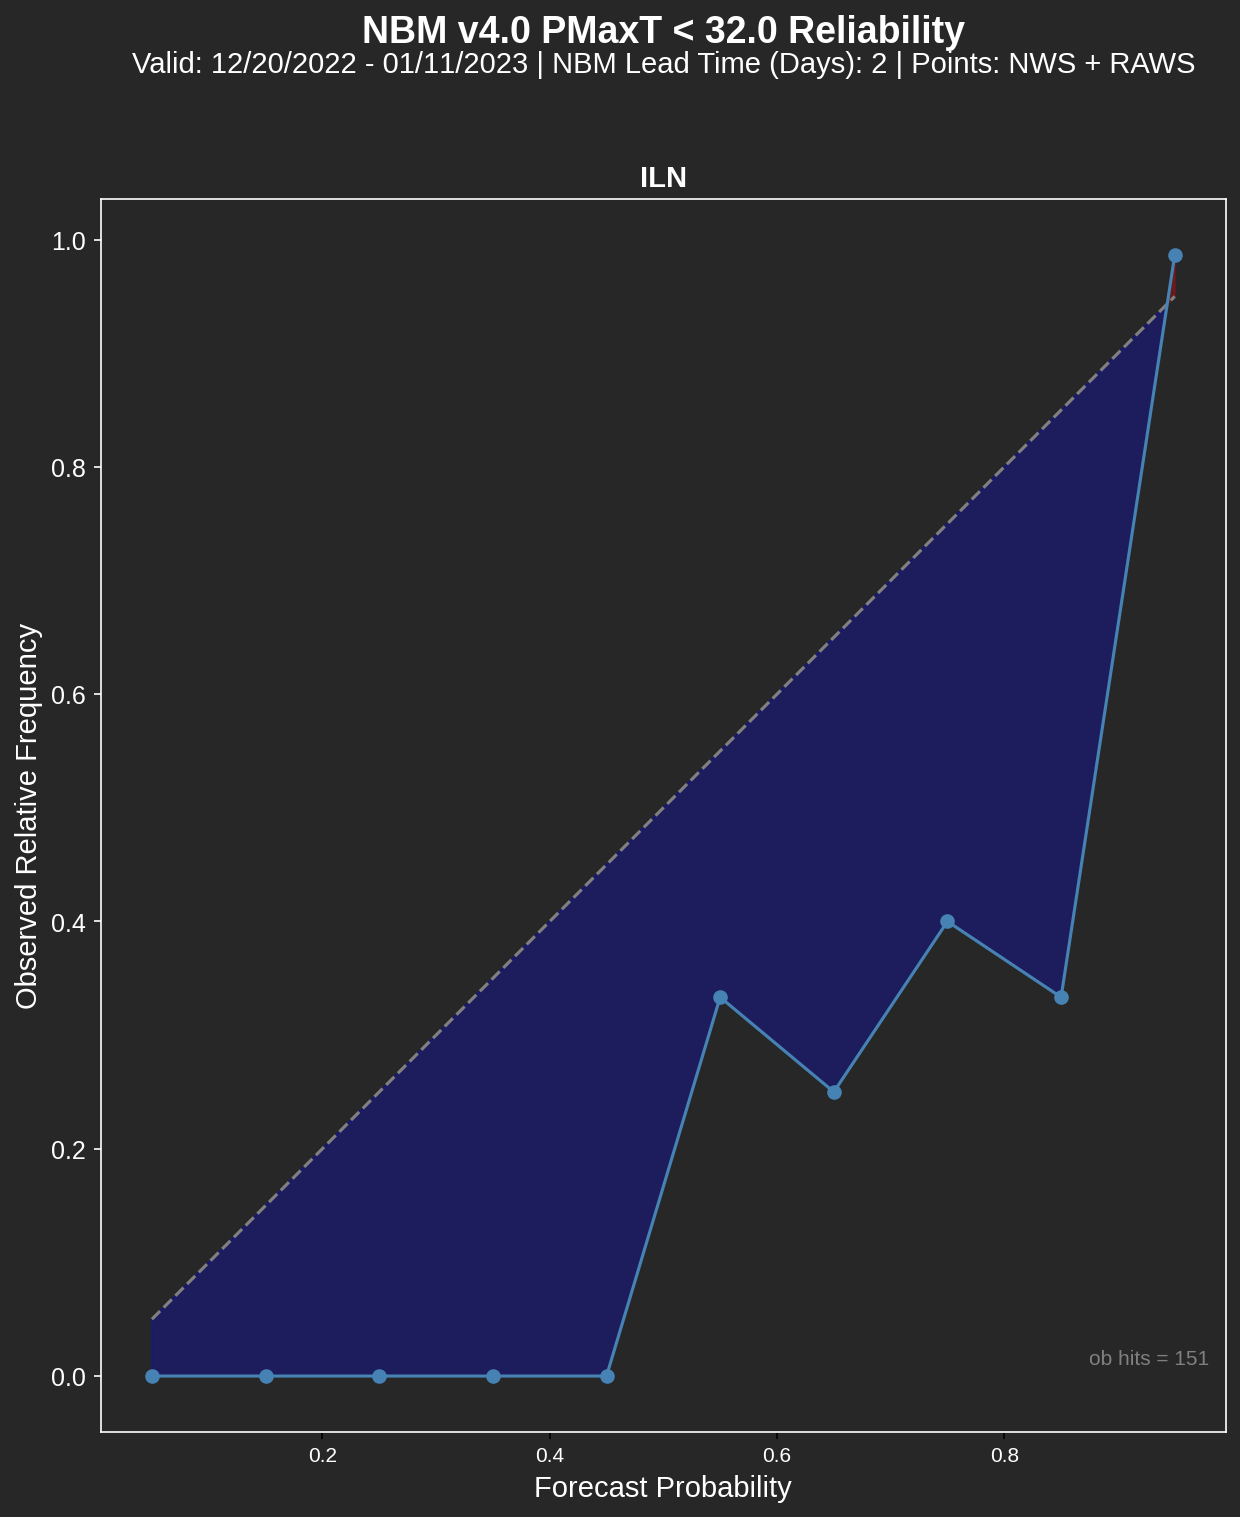

In [ ]:
#@title Make Plots
print("Making plots...")
if region_selection == "CONUS":
  summary_valid_title = start_date.strftime('%m/%d/%Y')+" - "+end_date.strftime('%m/%d/%Y')
  title_dict = {"maxt":["Max T","PMaxT"],"mint":["Min T","PMinT"], "qpf":["Precip","PQPF"]}
  background_color = '#272727'
  text_color = 'white'


  if element == "qpf":
    color1 = ['brown'] * 10
    color0 = ['teal'] * 10
  else:
    if percentile_stat == "nonexceedance":
      color0 = ['b'] * 10
      color1 = ['r'] * 10
    elif percentile_stat == "exceedance":
      color0 = ['r'] * 10
      color1 = ['b'] * 10

  matplotlib.rc('axes',facecolor=background_color, edgecolor='w')

  valid_title = valid_date.strftime('%a %m-%d-%Y')
  nbm_init_title = nbm_init.strftime('%HZ %m-%d-%Y')

  def flip(items, ncol):
          return itertools.chain(*[items[i::ncol] for i in range(ncol)])
  if percentile_stat == "nonexceedance":
    titlestring = f'NBM v4.0 {title_dict[element][1]} < {threshold} Reliability'
  elif percentile_stat == "exceedance":
    titlestring = f'NBM v4.0 {title_dict[element][1]} > {threshold} Reliability'

  fig = plt.figure(constrained_layout=True, figsize=(16,9), facecolor=background_color, frameon=True, dpi=150)
  #grid = fig.add_gridspec(4,4, width_ratios=width_ratios, hspace=0.2, wspace=0.2, left=0.1, right=0.9)
  width_ratios = [2,1,1]
  grid = fig.add_gridspec(2,3, width_ratios=width_ratios)
  fig.text(0.5, 1.08, titlestring, horizontalalignment='center', verticalalignment='bottom', weight='bold',fontsize=25,color=text_color)
  if use_stageiv:
    fig.text(0.5, 1.08,f'Valid: {summary_valid_title} | NBM Lead Time (Days): {nbm_lead_time} | Points: Stage IV @ NWS + RAWS',horizontalalignment='center', verticalalignment='top', fontsize=16, color=text_color)
  else:
    fig.text(0.5, 1.08,f'Valid: {summary_valid_title} | NBM Lead Time (Days): {nbm_lead_time} | Points: NWS + RAWS',horizontalalignment='center', verticalalignment='top', fontsize=16, color=text_color)

  ax1 = fig.add_subplot(grid[:,:-2])
  ax2 = fig.add_subplot(grid[0,1])
  ax3 = fig.add_subplot(grid[0,2])
  ax4 = fig.add_subplot(grid[1,1])
  ax5 = fig.add_subplot(grid[1,2])

  conus_df = pd.concat([bulk_stats["WR"], bulk_stats["CR"], bulk_stats["ER"], bulk_stats["SR"]])

  ys = []
  xs = [0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95]
  for p in range(10,110,10):
    if percentile_stat == "nonexceedance":
      try:
        ys.append(len(conus_df[(conus_df.ob < float(threshold)) & (conus_df.prob_exceedance <= p) & (conus_df.prob_exceedance > (p-10))]) / len(conus_df[(conus_df.prob_exceedance <= p) & (conus_df.prob_exceedance > (p-10))]))
      except:
        ys.append(np.nan)
    else:
      try:
        ys.append(len(conus_df[(conus_df.ob > float(threshold)) & (conus_df.prob_exceedance <= p) & (conus_df.prob_exceedance > (p-10))]) / len(conus_df[(conus_df.prob_exceedance <= p) & (conus_df.prob_exceedance > (p-10))]))
      except:
        ys.append(np.nan)
  if np.isnan(ys).any():
    print("Uh-oh, you got some empty bins, might want to double-check some things")
    ys_tointerp = pd.Series(ys)
    ys = ys_tointerp.interpolate()

  ax1.set_aspect('equal')
  ax1.plot(xs, xs, color='grey', linestyle='--')
  ax1.plot(xs, ys, color='steelblue', marker='o')
  for tick in ax1.get_xticklabels():
    tick.set_color(text_color)
  for tick in ax1.get_yticklabels():
    tick.set_color(text_color)
  ax1.tick_params(axis='y',labelsize=8, color=text_color)
  ax1.set_title("CONUS", color=text_color, fontsize=14, weight='bold')
  ax1.set_xlabel("Forecast Probability", color=text_color, fontsize=10)
  ax1.set_ylabel("Observed Relative Frequency", color=text_color, fontsize=10)
  ax1.fill_between(xs, ys, xs, where=(np.subtract(ys, xs) > 0), interpolate=True, color=color1, alpha=0.25)
  ax1.fill_between(xs, xs, ys, where=(np.subtract(ys, xs) < 0), interpolate=True, color=color0, alpha=0.25)

  region_ys = {}
  for region in region_list:
    if not region in region_ys.keys():
      region_ys[region] = []

    for p in range(10,110,10):
      if percentile_stat == "nonexceedance":
        try:
          region_ys[region].append(len(bulk_stats[region][(bulk_stats[region].ob < float(threshold)) & (bulk_stats[region].prob_exceedance <= p) & (bulk_stats[region].prob_exceedance > (p-10))]) / len(bulk_stats[region][(bulk_stats[region].prob_exceedance <= p) & (bulk_stats[region].prob_exceedance > (p-10))]))
        except:
          region_ys[region].append(np.nan)
      else:
        try:
          region_ys[region].append(len(bulk_stats[region][(bulk_stats[region].ob > float(threshold)) & (bulk_stats[region].prob_exceedance <= p) & (bulk_stats[region].prob_exceedance > (p-10))]) / len(bulk_stats[region][(bulk_stats[region].prob_exceedance <= p) & (bulk_stats[region].prob_exceedance > (p-10))]))
        except:
          region_ys[region].append(np.nan)

    if np.isnan(region_ys[region]).any():
      print(f'  {region} has at least one empty bin')
      ys_region_tointerp = pd.Series(region_ys[region])
      region_ys[region] = ys_region_tointerp.interpolate()

  ax2.set_aspect('equal')
  ax2.plot(xs, xs, color='grey', linestyle='--')
  ax2.plot(xs, region_ys["WR"], color='steelblue', marker='o')
  for tick in ax2.get_xticklabels():
    tick.set_color(text_color)
  for tick in ax2.get_yticklabels():
    tick.set_color(text_color)
  ax2.tick_params(axis='y',labelsize=8, color=text_color)
  ax2.set_xlabel("Forecast Probability", color=text_color, fontsize=10)
  ax2.set_ylabel("Observed Relative Frequency", color=text_color, fontsize=10)
  ax2.set_title("Western Region", color=text_color, fontsize=14, weight='bold')
  ax2.fill_between(xs, region_ys["WR"], xs, where=(np.subtract(region_ys["WR"], xs) > 0), interpolate=True, color=color1, alpha=0.25)
  ax2.fill_between(xs, xs, region_ys["WR"], where=(np.subtract(region_ys["WR"], xs) < 0), interpolate=True, color=color0, alpha=0.25)


  ax3.set_aspect('equal')
  ax3.plot(xs, xs, color='grey', linestyle='--')
  ax3.plot(xs, region_ys["CR"], color='steelblue', marker='o')
  for tick in ax3.get_xticklabels():
    tick.set_color(text_color)
  for tick in ax3.get_yticklabels():
    tick.set_color(text_color)
  ax3.tick_params(axis='y',labelsize=8, color=text_color)
  ax3.set_xlabel("Forecast Probability", color=text_color, fontsize=10)
  ax3.set_ylabel("Observed Relative Frequency", color=text_color, fontsize=10)
  ax3.set_title("Central Region", color=text_color, fontsize=14, weight='bold')
  ax3.fill_between(xs, region_ys["CR"], xs, where=(np.subtract(region_ys["CR"], xs) > 0), interpolate=True, color=color1, alpha=0.25)
  ax3.fill_between(xs, xs, region_ys["CR"], where=(np.subtract(region_ys["CR"], xs) < 0), interpolate=True, color=color0, alpha=0.25)


  ax4.set_aspect('equal')
  ax4.plot(xs, xs, color='grey', linestyle='--')
  ax4.plot(xs, region_ys["SR"], color='steelblue', marker='o')
  for tick in ax4.get_xticklabels():
    tick.set_color(text_color)
  for tick in ax4.get_yticklabels():
    tick.set_color(text_color)
  ax4.tick_params(axis='y',labelsize=8, color=text_color)
  ax4.set_xlabel("Forecast Probability", color=text_color, fontsize=10)
  ax4.set_ylabel("Observed Relative Frequency", color=text_color, fontsize=10)
  ax4.set_title("Southern Region", color=text_color, fontsize=14, weight='bold')
  ax4.fill_between(xs, region_ys["SR"], xs, where=(np.subtract(region_ys["SR"], xs) > 0), interpolate=True, color=color1, alpha=0.25)
  ax4.fill_between(xs, xs, region_ys["SR"], where=(np.subtract(region_ys["SR"], xs) < 0), interpolate=True, color=color0, alpha=0.25)


  ax5.set_aspect('equal')
  ax5.plot(xs, xs, color='grey', linestyle='--')
  ax5.plot(xs, region_ys["ER"], color='steelblue', marker='o')
  for tick in ax5.get_xticklabels():
    tick.set_color(text_color)
  for tick in ax5.get_yticklabels():
    tick.set_color(text_color)
  ax5.tick_params(axis='y',labelsize=8, color=text_color)
  ax5.set_xlabel("Forecast Probability", color=text_color, fontsize=10)
  ax5.set_ylabel("Observed Relative Frequency", color=text_color, fontsize=10)
  ax5.set_title("Eastern Region", color=text_color, fontsize=14, weight='bold')
  ax5.fill_between(xs, region_ys["ER"], xs, where=(np.subtract(region_ys["ER"], xs) > 0), interpolate=True, color=color1, alpha=0.25)
  ax5.fill_between(xs, xs, region_ys["ER"], where=(np.subtract(region_ys["ER"], xs) < 0), interpolate=True, color=color0, alpha=0.25)

  if percentile_stat == "nonexceedance":
    ax1.text(0.98,0.01,f'ob hits = {len(conus_df[(conus_df.ob < float(threshold-0.5))])}', horizontalalignment='right', size=10, color='grey')
    ax2.text(0.98,0.01,f'ob hits = {len(bulk_stats["WR"][bulk_stats["WR"].ob < float(threshold)])}', horizontalalignment='right', size=10, color='grey')
    ax3.text(0.98,0.01,f'ob hits = {len(bulk_stats["CR"][bulk_stats["CR"].ob < float(threshold)])}', horizontalalignment='right', size=10, color='grey')
    ax4.text(0.98,0.01,f'ob hits = {len(bulk_stats["SR"][bulk_stats["SR"].ob < float(threshold)])}', horizontalalignment='right', size=10, color='grey')
    ax5.text(0.98,0.01,f'ob hits = {len(bulk_stats["ER"][bulk_stats["ER"].ob < float(threshold)])}', horizontalalignment='right', size=10, color='grey')
  else:
    ax1.text(0.98,0.01,f'ob hits = {len(conus_df[(conus_df.ob > float(threshold))])}', horizontalalignment='right', size=10, color='grey')
    ax2.text(0.98,0.01,f'ob hits = {len(bulk_stats["WR"][bulk_stats["WR"].ob > float(threshold)])}', horizontalalignment='right', size=10, color='grey')
    ax3.text(0.98,0.01,f'ob hits = {len(bulk_stats["CR"][bulk_stats["CR"].ob > float(threshold)])}', horizontalalignment='right', size=10, color='grey')
    ax4.text(0.98,0.01,f'ob hits = {len(bulk_stats["SR"][bulk_stats["SR"].ob > float(threshold)])}', horizontalalignment='right', size=10, color='grey')
    ax5.text(0.98,0.01,f'ob hits = {len(bulk_stats["ER"][bulk_stats["ER"].ob > float(threshold)])}', horizontalalignment='right', size=10, color='grey')

else:

  if (region_selection == "CWA"):
    dataframeid = cwa_id
  else:
    dataframeid = region_selection

  summary_valid_title = start_date.strftime('%m/%d/%Y')+" - "+end_date.strftime('%m/%d/%Y')
  title_dict = {"maxt":["Max T","PMaxT"],"mint":["Min T","PMinT"], "qpf":["Precip","PQPF"]}
  background_color = '#272727'
  text_color = 'white'


  if element == "qpf":
    color1 = ['brown'] * 10
    color0 = ['teal'] * 10
  else:
    if percentile_stat == "nonexceedance":
      color0 = ['b'] * 10
      color1 = ['r'] * 10
    elif percentile_stat == "exceedance":
      color0 = ['r'] * 10
      color1 = ['b'] * 10

  matplotlib.rc('axes',facecolor=background_color, edgecolor='w')

  valid_title = valid_date.strftime('%a %m-%d-%Y')
  nbm_init_title = nbm_init.strftime('%HZ %m-%d-%Y')

  def flip(items, ncol):
          return itertools.chain(*[items[i::ncol] for i in range(ncol)])
  if percentile_stat == "nonexceedance":
    titlestring = f'NBM v4.0 {title_dict[element][1]} < {threshold} Reliability'
  elif percentile_stat == "exceedance":
    titlestring = f'NBM v4.0 {title_dict[element][1]} > {threshold} Reliability'

  fig = plt.figure(constrained_layout=True, figsize=(9,9), facecolor=background_color, frameon=True, dpi=150)
  #grid = fig.add_gridspec(4,4, width_ratios=width_ratios, hspace=0.2, wspace=0.2, left=0.1, right=0.9)

  fig.text(0.5, 1.08, titlestring, horizontalalignment='center', verticalalignment='bottom', weight='bold',fontsize=18,color=text_color)
  if use_stageiv:
    fig.text(0.5, 1.08,f'Valid: {summary_valid_title} | NBM Lead Time (Days): {nbm_lead_time} | Points: Stage IV @ NWS + RAWS',horizontalalignment='center', verticalalignment='top', fontsize=14, color=text_color)
  else:
    fig.text(0.5, 1.08,f'Valid: {summary_valid_title} | NBM Lead Time (Days): {nbm_lead_time} | Points: NWS + RAWS',horizontalalignment='center', verticalalignment='top', fontsize=14, color=text_color)

  ax1 = fig.add_subplot()


  #bulk_df = pd.concat([bulk_stats["WR"], bulk_stats["CR"], bulk_stats["ER"], bulk_stats["SR"]])

  ys = []
  xs = [0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95]
  for p in range(10,110,10):
    if percentile_stat == "nonexceedance":
      try:
        ys.append(len(bulk_stats[dataframeid][(bulk_stats[dataframeid].ob < float(threshold)) & (bulk_stats[dataframeid].prob_exceedance <= p) & (bulk_stats[dataframeid].prob_exceedance > (p-10))]) / len(bulk_stats[dataframeid][(bulk_stats[dataframeid].prob_exceedance <= p) & (bulk_stats[dataframeid].prob_exceedance > (p-10))]))
      except:
        ys.append(np.nan)
    else:
      try:
        ys.append(len(bulk_stats[dataframeid][(bulk_stats[dataframeid].ob > float(threshold)) & (bulk_stats[dataframeid].prob_exceedance <= p) & (bulk_stats[dataframeid].prob_exceedance > (p-10))]) / len(bulk_stats[dataframeid][(bulk_stats[dataframeid].prob_exceedance <= p) & (bulk_stats[dataframeid].prob_exceedance > (p-10))]))
      except:
        ys.append(np.nan)
  if np.isnan(ys).any():
    print("Uh-oh, you got some empty bins, might want to double-check some things")
    ys_tointerp = pd.Series(ys)
    ys = ys_tointerp.interpolate()

  ax1.set_aspect('equal')
  ax1.plot(xs, xs, color='grey', linestyle='--')
  ax1.plot(xs, ys, color='steelblue', marker='o')
  for tick in ax1.get_xticklabels():
    tick.set_color(text_color)
  for tick in ax1.get_yticklabels():
    tick.set_color(text_color)
  ax1.tick_params(axis='y',labelsize=12, color=text_color)
  ax1.set_title(dataframeid, color=text_color, fontsize=14, weight='bold')
  ax1.set_xlabel("Forecast Probability", color=text_color, fontsize=14)
  ax1.set_ylabel("Observed Relative Frequency", color=text_color, fontsize=14)
  ax1.fill_between(xs, ys, xs, where=(np.subtract(ys, xs) > 0), interpolate=True, color=color1, alpha=0.25)
  ax1.fill_between(xs, xs, ys, where=(np.subtract(ys, xs) < 0), interpolate=True, color=color0, alpha=0.25)


  if percentile_stat == "nonexceedance":
    ax1.text(0.98,0.01,f'ob hits = {len(bulk_stats[dataframeid][(bulk_stats[dataframeid].ob < float(threshold))])}', horizontalalignment='right', size=10, color='grey')

  else:
    ax1.text(0.98,0.01,f'ob hits = {len(bulk_stats[dataframeid][(bulk_stats[dataframeid].ob > float(threshold))])}', horizontalalignment='right', size=10, color='grey')

figname=region_name+"_"+element+"_"+str(threshold)+"_reliability.png"
plt.savefig(figname, facecolor=fig.get_facecolor(), bbox_inches='tight', pad_inches=0.2, dpi='figure')